In [1]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2, ToTensor
from torchvision.io import read_image, ImageReadMode
import torch
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch import nn

from sklearn.metrics import accuracy_score

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

In [2]:
test_path = './data/train/Adult/adults_ (1).jpg'

img = Image.open(test_path).convert('RGB')

trans = v2.Compose([
    ToTensor(),
    v2.Resize(size=(256,256), antialias=True),
])

img = trans(img)

print(img.shape)
print(type(img))
print(img.dtype)

print(img)

torch.Size([3, 256, 256])
<class 'torch.Tensor'>
torch.float32
tensor([[[0.1625, 0.1685, 0.1745,  ..., 0.3230, 0.3473, 0.3766],
         [0.1640, 0.1684, 0.1730,  ..., 0.3199, 0.3470, 0.3769],
         [0.1625, 0.1648, 0.1654,  ..., 0.3218, 0.3515, 0.3823],
         ...,
         [0.0662, 0.0690, 0.0708,  ..., 0.1569, 0.1584, 0.1557],
         [0.0802, 0.0833, 0.0849,  ..., 0.1453, 0.1434, 0.1430],
         [0.0873, 0.0911, 0.0930,  ..., 0.1384, 0.1321, 0.1348]],

        [[0.0527, 0.0579, 0.0609,  ..., 0.3078, 0.3460, 0.3793],
         [0.0542, 0.0584, 0.0606,  ..., 0.3154, 0.3513, 0.3807],
         [0.0534, 0.0553, 0.0548,  ..., 0.3212, 0.3551, 0.3859],
         ...,
         [0.0505, 0.0533, 0.0551,  ..., 0.0615, 0.0583, 0.0562],
         [0.0645, 0.0676, 0.0692,  ..., 0.0546, 0.0531, 0.0496],
         [0.0716, 0.0754, 0.0773,  ..., 0.0454, 0.0445, 0.0401]],

        [[0.0390, 0.0425, 0.0449,  ..., 0.5272, 0.5849, 0.6327],
         [0.0424, 0.0443, 0.0440,  ..., 0.5395, 0.5935, 0.63

In [3]:
train_csv = './data/train_dataset.csv'
train_df = shuffle(pd.read_csv(train_csv))
test_csv = './data/test_dataset.csv'
test_df = shuffle(pd.read_csv(test_csv))

le = LabelEncoder().fit(list(train_df['label'].values) + list(test_df['label'].values))

train_df['label_id'] = le.transform(train_df['label'].values)
test_df['label_id'] = le.transform(test_df['label'].values)

In [4]:
print(train_df.shape)
train_df.head()



(1838, 4)


,Unnamed: 0,path,label,label_id
1822,1822,e:\ML\ml_projects\image_classification-kaggle_...,Vessel,15
745,745,e:\ML\ml_projects\image_classification-kaggle_...,Cat,6
1427,1427,e:\ML\ml_projects\image_classification-kaggle_...,Monkey,12
616,616,e:\ML\ml_projects\image_classification-kaggle_...,Car,5
1428,1428,e:\ML\ml_projects\image_classification-kaggle_...,Monkey,12


In [5]:
print(test_df.shape)
test_df.head()

(480, 4)


,Unnamed: 0,path,label,label_id
23,23,e:\ML\ml_projects\image_classification-kaggle_...,Adult,0
287,287,e:\ML\ml_projects\image_classification-kaggle_...,Flower,9
188,188,e:\ML\ml_projects\image_classification-kaggle_...,Cat,6
98,98,e:\ML\ml_projects\image_classification-kaggle_...,Bird,3
395,395,e:\ML\ml_projects\image_classification-kaggle_...,Panda,13


In [6]:
class ImageDataset(Dataset):
    def __init__(self, csv_path, transform_compose = None):
        #use the csv file to load the dataset
        self.transform_compose = transform_compose
        self.df = pd.read_csv(csv_path)
        self.length = self.df.shape[0]
        self.label_count = len(set(self.df['label']))

        #convert categorical labels to number
        self.le = LabelEncoder().fit(self.df['label'])
        converted_labels = self.le.transform(self.df['label'].values)

        self.df['label_id'] = converted_labels
    
    def get_string_label(self, label):
        return self.le.inverse_transform(label)

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        path = row['path']
        label_id = row['label_id']
        img = Image.open(path).convert('RGB')
        tensor = self.transform_compose(img)
        return tensor, torch.tensor(label_id).to(torch.float32)

In [7]:
compose = v2.Compose([
    ToTensor(),
    v2.Resize(size=(256,256), antialias=True),
])

train_dataset = ImageDataset(csv_path= './data/train_dataset.csv', transform_compose=compose)
inputs, label = train_dataset[0]
train_dataloader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

test_dataset = ImageDataset(csv_path= './data/test_dataset.csv', transform_compose=compose)
batch = test_dataset.df.shape[0]
test_dataloader = DataLoader(test_dataset, batch_size = batch, shuffle = True)

# Showing sample images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


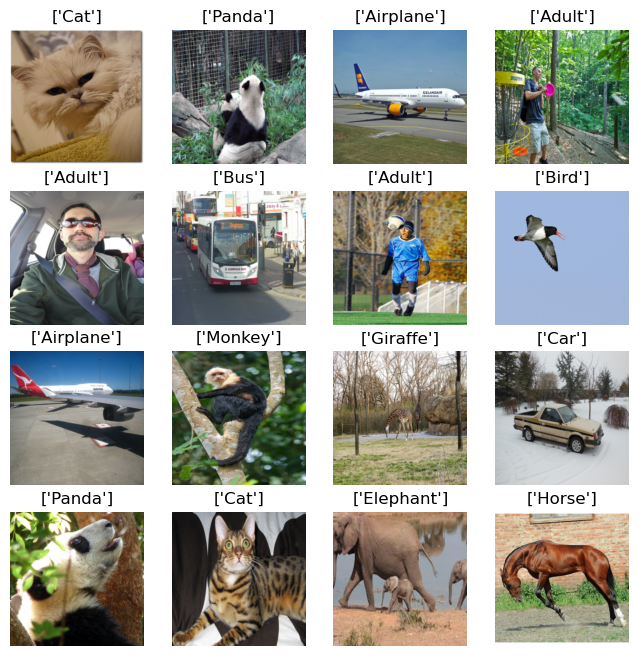

label count =  16


In [8]:
data = next(iter(train_dataloader))

inputs, labels = data
label_value = labels[0].item()

rows = cols = 4 
figure = plt.figure(figsize=(8,8))
for i in range(16):
    figure.add_subplot(rows, cols, i + 1)
    label_value = labels[i].item()
    plt.imshow(np.transpose(inputs[i], (1,2,0)))
    plt.axis('off')
    plt.title(train_dataset.get_string_label([int(label_value)]))
plt.show()

print('label count = ', train_dataset.label_count)



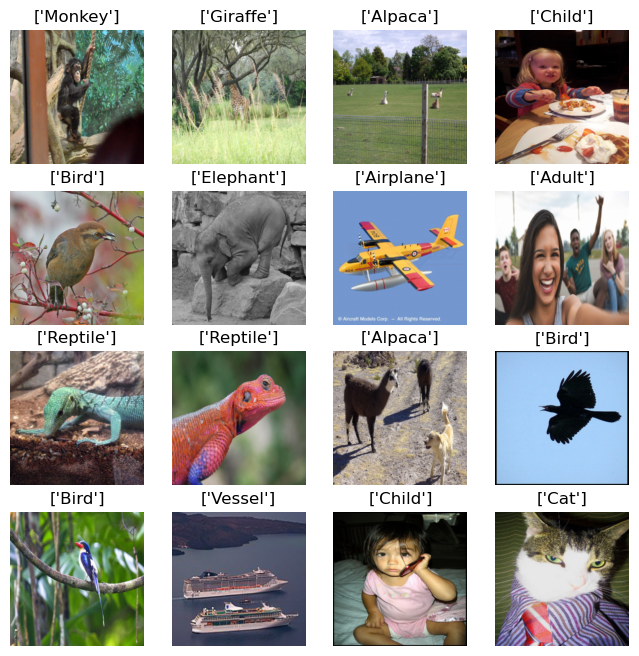

label count =  16


In [9]:
data = next(iter(test_dataloader))

inputs, labels = data

rows = cols = 4 
figure = plt.figure(figsize=(8,8))
for i in range(16):
    figure.add_subplot(rows, cols, i + 1)
    label_value = labels[i].item()
    plt.imshow(np.transpose(inputs[i], (1,2,0)))
    plt.axis('off')
    plt.title(train_dataset.get_string_label([int(label_value)]))
plt.show()

print('label count = ', train_dataset.label_count)

In [10]:
print(inputs.shape)

torch.Size([480, 3, 256, 256])


In [11]:
def build_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels= 16, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Conv2d(in_channels = 16, out_channels=32, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Flatten(),
        nn.LazyLinear(512),
        nn.ReLU(),
        nn.LazyLinear(16),
    )

    return model

In [12]:
class EarlyStopping():
    def __init__(self, tolerance = 5, min_delta = 10):
        self.tolerance = tolerance
        self.min_delta = min_delta 
        self.counter = 0
        self.early_stopping = False
    
    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) < self.min_delta:
            self.counter += 1

            if self.counter > self.tolerance:
                self.early_stopping = True


def score(model, X, y):
    with torch.no_grad():
        model.eval()
        data = next(iter(test_dataloader))

        outputs = model(X)
        y_pred = torch.max(outputs, 1)
        y_pred = y_pred[1].cpu().numpy()
        y = y.cpu().numpy()
        accuracy = accuracy_score(y, y_pred)

        model.train()
        return accuracy

def train(model, dataloader, optimizer, criterion, device, epochs = 40, debug = True):
    loss_values = []
    accuracy_values = []

    test_data = next(iter(test_dataloader))
    X_test, y_test = test_data
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for e in range(epochs):

        running_loss = 0.0

        for batch, data in enumerate(dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            #Have to convert the labels back to LongTensor. for some reaons, CUDA don't accept torch.float32
            labels = labels.type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
        
        accuracy = score(model, X_test,y_test)

        loss_values.append(running_loss) 
        accuracy_values.append(accuracy) 

        if debug:
            print(f'epoch={e}, loss = {running_loss}, accuracy = {accuracy}')
    
    return {'loss': loss_values, 'accuracy': accuracy_values}

def performance_plot(history):
    sns.lineplot(x = list(range(len(history['loss']))), y = history['loss'], color = 'red', label = 'loss')
    plt.show()
    sns.lineplot(x = list(range(len(history['accuracy']))), y = history['accuracy'], color = 'orange', label = 'accuracy')
    plt.show()




Running on cuda


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch=0, loss = 318.6779978275299, accuracy = 0.0625


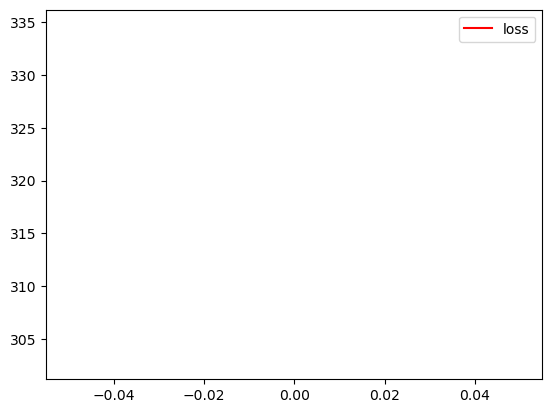

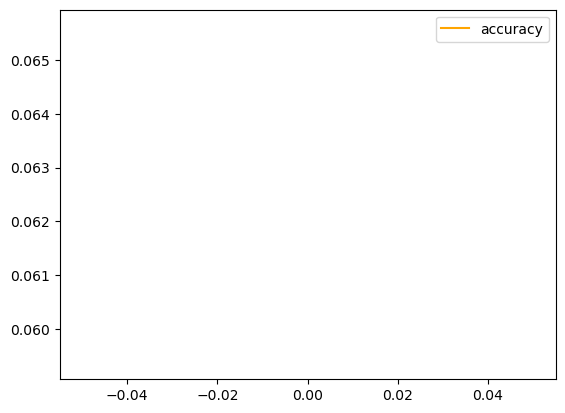

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
model = build_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
history = train(model, train_dataloader, optimizer, criterion, device)

performance_plot(history)

#save model


In [ ]:
torch.save(model.state_dict(), 'model1_100epoch.torch')

In [ ]:
model_path = 'model1_100epoch.torch'
model.load_state_dict(torch.load(model_path))
model.eval()

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=25088, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=16, bias=True)
)

# Evaluate prodedure

In [113]:

torch.save(model, 'model1_100epoch.torch')

In [59]:
#Load the entire model

model = torch.load('model1_100epoch.torch')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [16]:
#Model with sigmoid activation
def build_model1():
    model = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels= 16, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Conv2d(in_channels = 16, out_channels=32, kernel_size= 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(3),
        nn.Flatten(),
        nn.LazyLinear(512),
        nn.Sigmoid(),
        nn.LazyLinear(16),
    )

    return model

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
model = build_model1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
history = train(model, train_dataloader, optimizer, criterion, device, epochs = 50)

performance_plot(history)

Running on cuda


c:\Users\nguye\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch=0, loss = 320.7827081680298, accuracy = 0.0625
epoch=1, loss = 319.50099444389343, accuracy = 0.07083333333333333
epoch=2, loss = 317.9734399318695, accuracy = 0.0875
epoch=3, loss = 314.56911635398865, accuracy = 0.13958333333333334
epoch=4, loss = 309.3994393348694, accuracy = 0.11875
epoch=5, loss = 302.79717803001404, accuracy = 0.12708333333333333
epoch=6, loss = 294.01240396499634, accuracy = 0.17291666666666666
epoch=7, loss = 287.22272086143494, accuracy = 0.16041666666666668
epoch=8, loss = 280.9268146753311, accuracy = 0.13541666666666666
epoch=9, loss = 276.0204393863678, accuracy = 0.2
epoch=10, loss = 270.7708011865616, accuracy = 0.18958333333333333
epoch=11, loss = 267.2296121120453, accuracy = 0.16875
epoch=12, loss = 259.1040027141571, accuracy = 0.18333333333333332
epoch=13, loss = 255.30763244628906, accuracy = 0.19583333333333333
epoch=14, loss = 247.9980789422989, accuracy = 0.21041666666666667
epoch=15, loss = 243.30813455581665, accuracy = 0.227083333333333

KeyboardInterrupt: 